
Class distribution (ham=0, spam=1):
 class
0    2788
1    1813
Name: count, dtype: int64


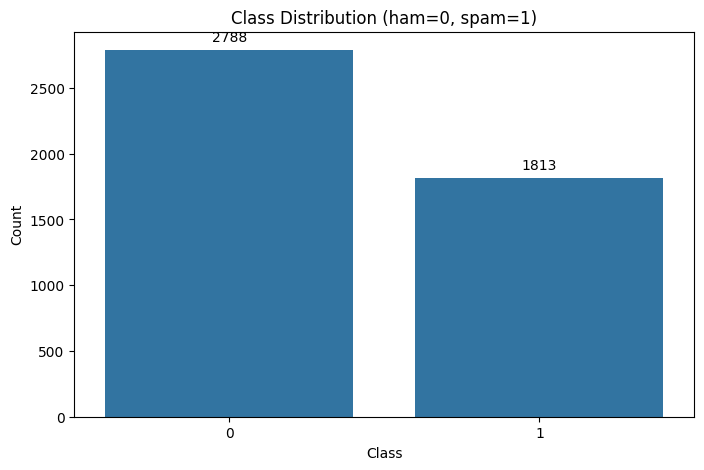


Top 10 features by variance:
 ['capital_run_length_total', 'capital_run_length_longest', 'capital_run_length_average', 'word_freq_george', 'word_freq_you', 'word_freq_hp', 'word_freq_3d', 'word_freq_address', 'word_freq_your', 'word_freq_font']


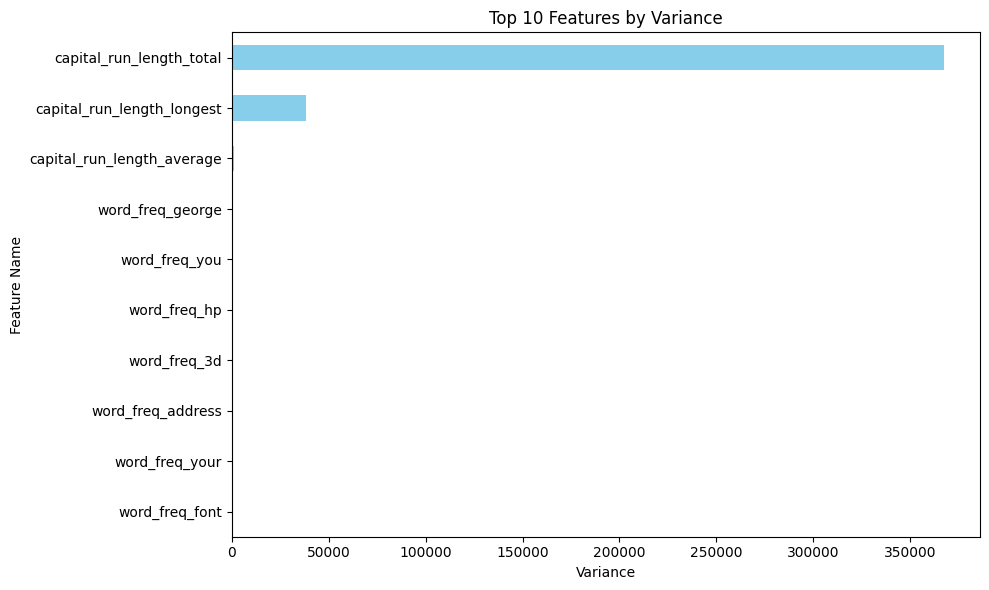

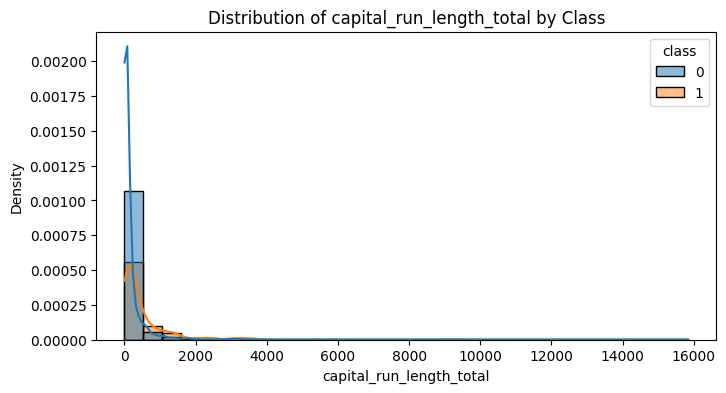

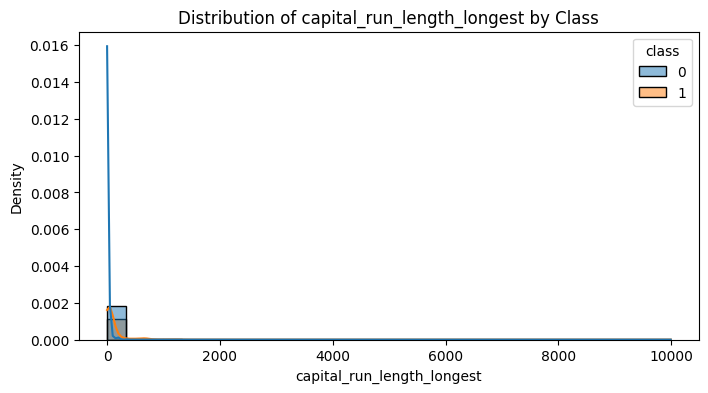

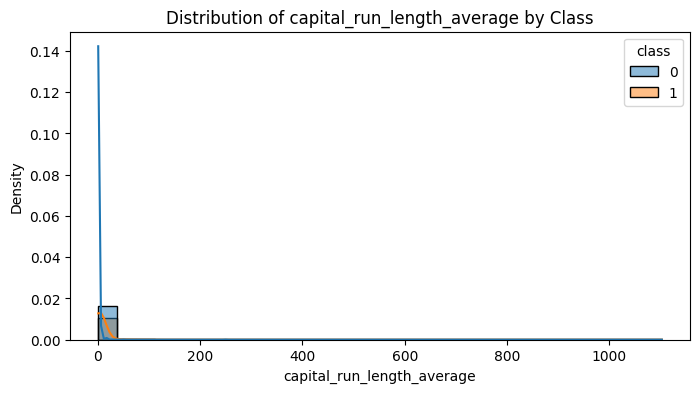

Training Naive Bayes variants:


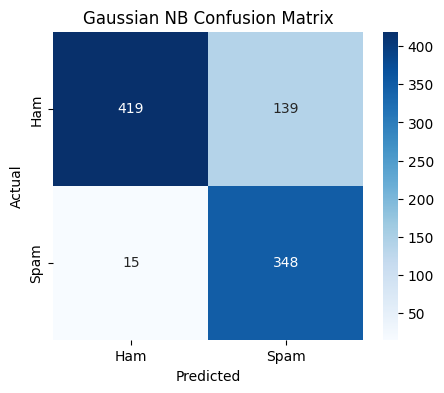

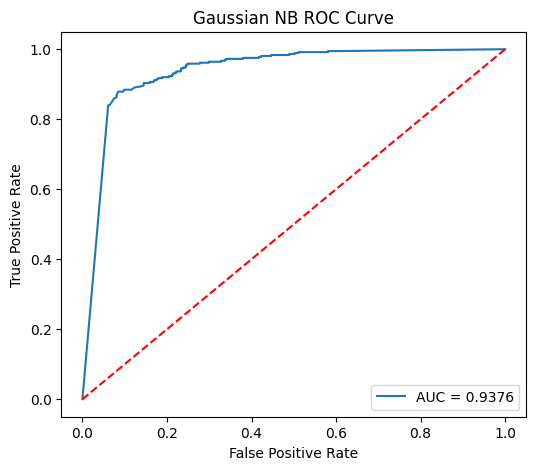

Gaussian NB metrics: Accuracy=0.8328, Precision=0.7146, Recall=0.9587, F1=0.8188, AUC=0.9376


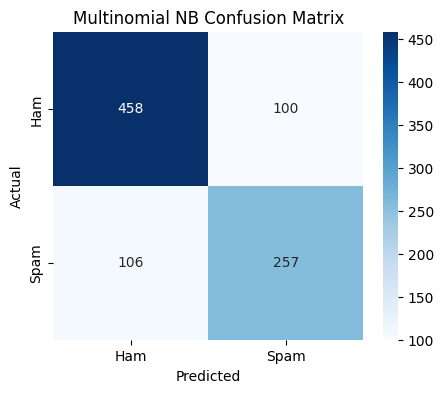

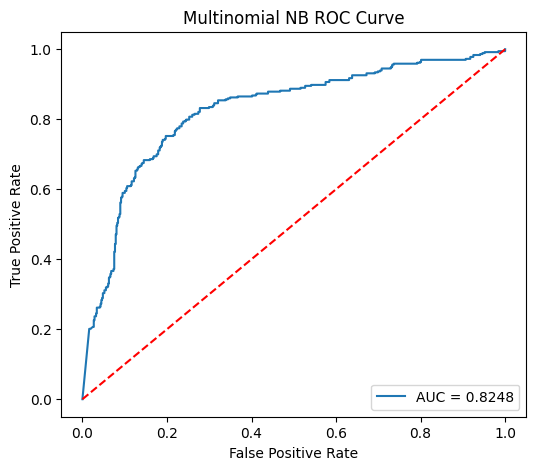

Multinomial NB metrics: Accuracy=0.7763, Precision=0.7199, Recall=0.7080, F1=0.7139, AUC=0.8248


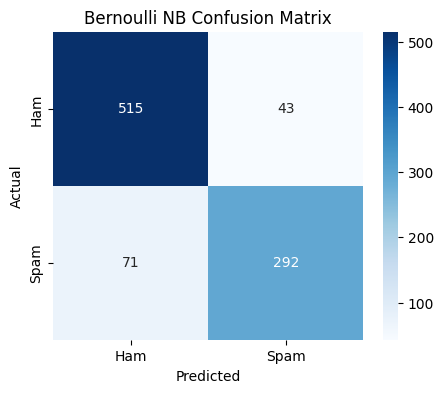

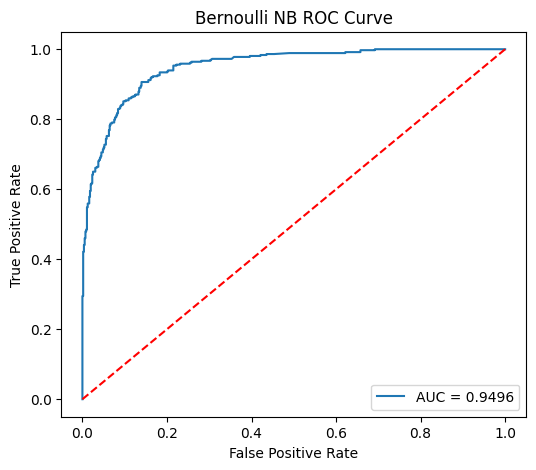

Bernoulli NB metrics: Accuracy=0.8762, Precision=0.8716, Recall=0.8044, F1=0.8367, AUC=0.9496

Table 1: Naïve Bayes Variant Comparison
                Accuracy  Precision    Recall  F1 Score       AUC
Gaussian NB     0.832790   0.714579  0.958678  0.818824  0.937602
Multinomial NB  0.776330   0.719888  0.707989  0.713889  0.824812
Bernoulli NB    0.876221   0.871642  0.804408  0.836676  0.949646

Training KNN for k=1,3,5,7:


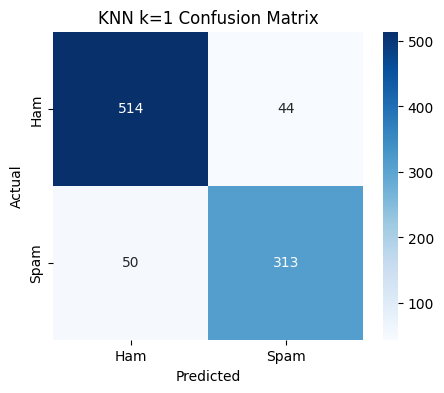

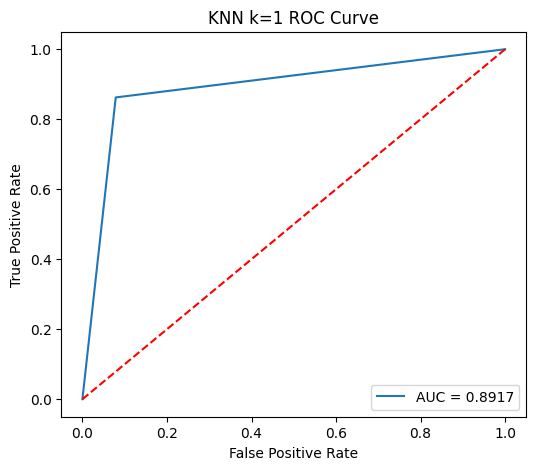

KNN k=1 metrics: Accuracy=0.8979, Precision=0.8768, Recall=0.8623, F1=0.8694, AUC=0.8917


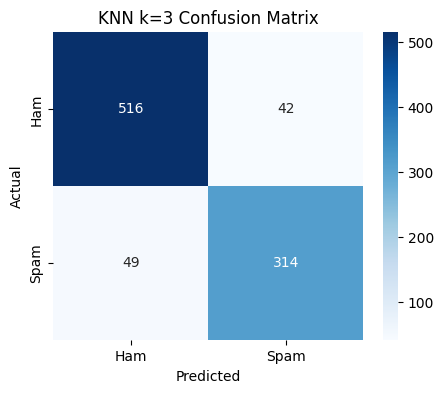

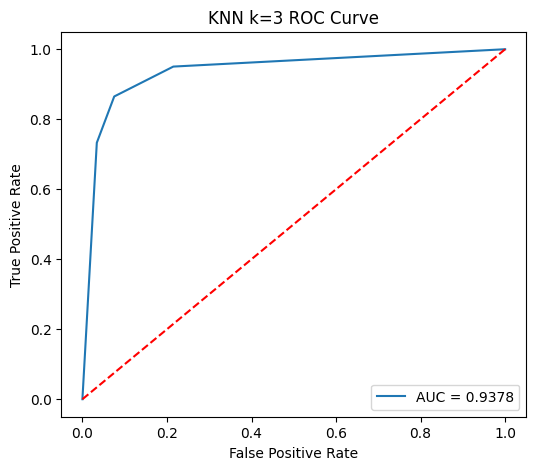

KNN k=3 metrics: Accuracy=0.9012, Precision=0.8820, Recall=0.8650, F1=0.8734, AUC=0.9378


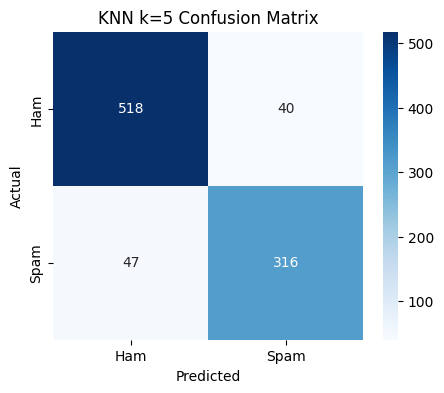

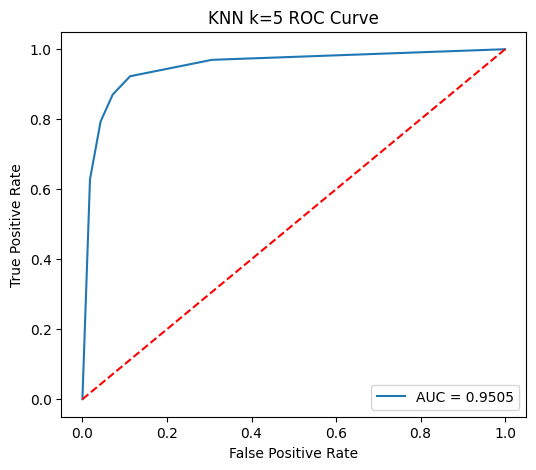

KNN k=5 metrics: Accuracy=0.9055, Precision=0.8876, Recall=0.8705, F1=0.8790, AUC=0.9505


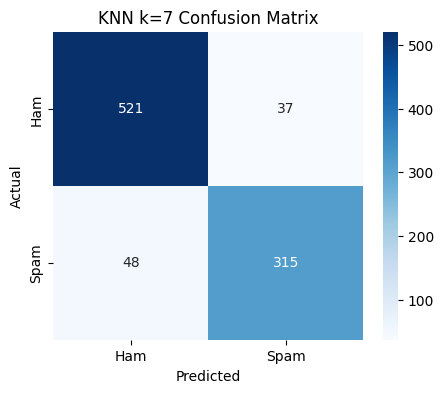

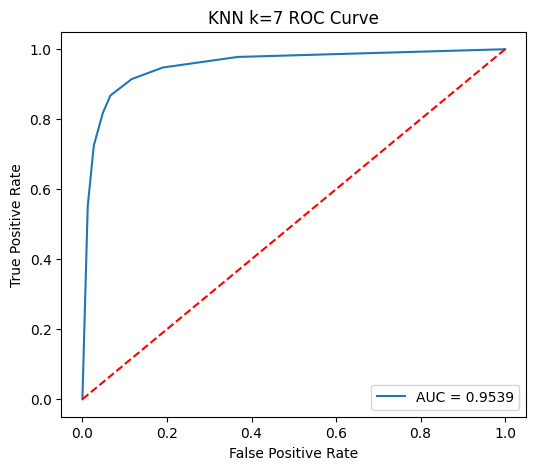

KNN k=7 metrics: Accuracy=0.9077, Precision=0.8949, Recall=0.8678, F1=0.8811, AUC=0.9539

Table 2: KNN Performance for Different k Values
         Accuracy  Precision    Recall  F1 Score       AUC
KNN k=1  0.897937   0.876751  0.862259  0.869444  0.891703
KNN k=3  0.901194   0.882022  0.865014  0.873435  0.937775
KNN k=5  0.905537   0.887640  0.870523  0.878999  0.950468
KNN k=7  0.907709   0.894886  0.867769  0.881119  0.953896

Table 3: KNN Comparison KDTree vs BallTree
                     KDTree  BallTree
Accuracy           0.905537  0.905537
Precision          0.887640  0.887640
Recall             0.870523  0.870523
F1 Score           0.878999  0.878999
Training Time (s)  0.050600  0.018100

Training SVM variants with default parameters:


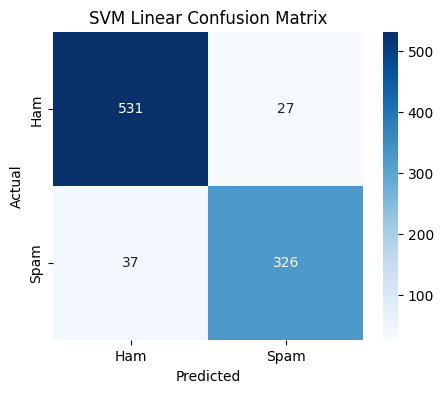

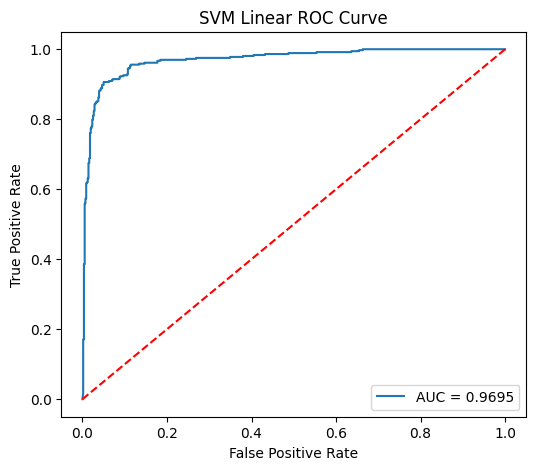

SVM Linear metrics: Accuracy=0.9305, Precision=0.9235, Recall=0.8981, F1=0.9106, AUC=0.9695


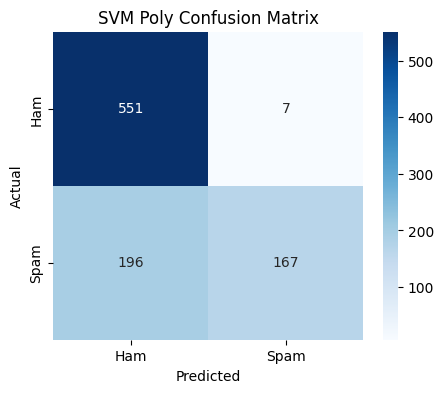

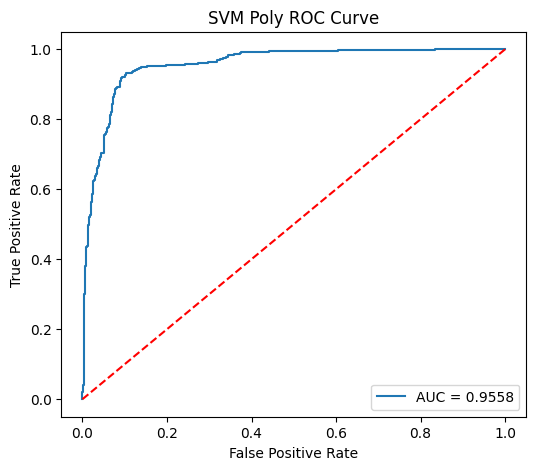

SVM Poly metrics: Accuracy=0.7796, Precision=0.9598, Recall=0.4601, F1=0.6220, AUC=0.9558


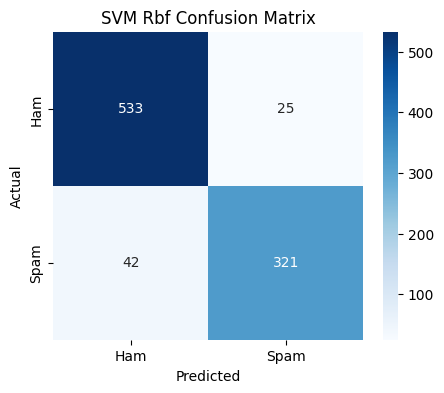

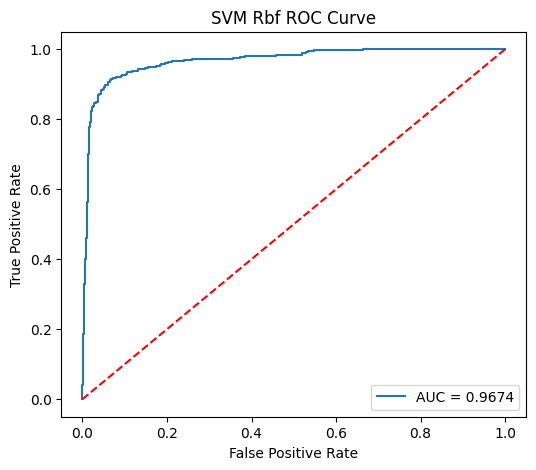

SVM Rbf metrics: Accuracy=0.9273, Precision=0.9277, Recall=0.8843, F1=0.9055, AUC=0.9674


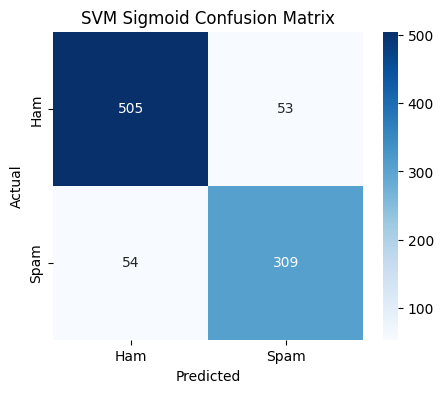

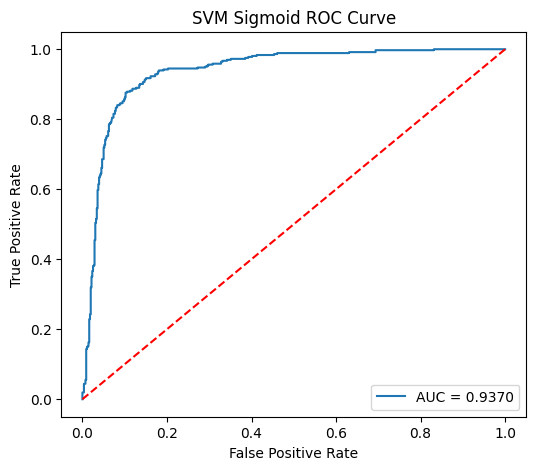

SVM Sigmoid metrics: Accuracy=0.8838, Precision=0.8536, Recall=0.8512, F1=0.8524, AUC=0.9370

Table 4 Part 1: SVM Kernels Performance (Default Params)
             Accuracy  Precision    Recall  F1 Score       AUC
SVM Linear   0.930510   0.923513  0.898072  0.910615  0.969450
SVM Poly     0.779587   0.959770  0.460055  0.621974  0.955819
SVM Rbf      0.927253   0.927746  0.884298  0.905501  0.967401
SVM Sigmoid  0.883822   0.853591  0.851240  0.852414  0.937000

GridSearchCV for SVM:


In [ ]:
# -*- coding: utf-8 -*-
"""Untitled11.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1mAE7qph1mNEk4wigp6vs4LxxjZW4Get0
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('/content/spambase_csv.csv')

# Set features & target assuming 'class' is target column
X = data.drop('class', axis=1)
y = data['class']

# EDA
print("\nClass distribution (ham=0, spam=1):\n", y.value_counts())
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y)
plt.title("Class Distribution (ham=0, spam=1)")
plt.xlabel("Class")
plt.ylabel("Count")

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

# Top 10 features with highest variance (simple proxy for importance)
top10_features = X.var().sort_values(ascending=False).head(10).index.tolist()
print("\nTop 10 features by variance:\n", top10_features)
plt.figure(figsize=(10, 6))
X[top10_features].var().sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Features by Variance")
plt.xlabel("Variance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# Plot feature distributions (for first top 3 features as sample)
for feat in top10_features[:3]:
    plt.figure(figsize=(8,4))
    sns.histplot(data, x=feat, hue='class', bins=30, kde=True, stat="density")
    plt.title(f'Distribution of {feat} by Class')
    plt.show()

# Scale features for KNN and SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80-20 stratified)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_orig, X_test_orig, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)  # for NB

def plot_confusion_and_roc(name, y_test, y_pred, y_proba=None):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.title(f"{name} ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
        return roc_auc
    else:
        return None

def evaluate(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = plot_confusion_and_roc(name, y_test, y_pred, y_proba)

    print(f"{name} metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}" if auc_score is not None else
          f"{name} metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'AUC': auc_score}

# 1. Naive Bayes Variants (no hyperparameter tuning)
print("Training Naive Bayes variants:")
nb_results = {}

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
nb_results['Gaussian NB'] = evaluate('Gaussian NB', gnb, X_test_scaled, y_test)

mnb = MultinomialNB()
mnb.fit(X_train_orig, y_train)
nb_results['Multinomial NB'] = evaluate('Multinomial NB', mnb, X_test_orig, y_test)

bnb = BernoulliNB()
bnb.fit(X_train_orig, y_train)
nb_results['Bernoulli NB'] = evaluate('Bernoulli NB', bnb, X_test_orig, y_test)

nb_df = pd.DataFrame(nb_results).T

# =========== TABLE 1: Naïve Bayes Variant Comparison ===========
print("\nTable 1: Naïve Bayes Variant Comparison")
print(nb_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])

# 2. KNN with k=1,3,5,7 (algorithm='auto', weights='uniform')
print("\nTraining KNN for k=1,3,5,7:")
knn_results = {}
for k in [1,3,5,7]:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='auto', weights='uniform')
    knn.fit(X_train_scaled, y_train)
    knn_results[f'KNN k={k}'] = evaluate(f'KNN k={k}', knn, X_test_scaled, y_test)

knn_df = pd.DataFrame(knn_results).T

# =========== TABLE 2: KNN Performance for Different k Values ===========
print("\nTable 2: KNN Performance for Different k Values")
print(knn_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])

# 3. KNN KDTree vs BallTree (k=5)
def train_and_eval_knn_algo(algorithm):
    knn_model = KNeighborsClassifier(n_neighbors=5, algorithm=algorithm)
    start_time = time.time()
    knn_model.fit(X_train_scaled, y_train)
    training_time = round(time.time() - start_time, 4)

    y_pred = knn_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return acc, prec, rec, f1, training_time

kd_acc, kd_prec, kd_rec, kd_f1, kd_time = train_and_eval_knn_algo('kd_tree')
ball_acc, ball_prec, ball_rec, ball_f1, ball_time = train_and_eval_knn_algo('ball_tree')

knn_tree_table = pd.DataFrame({
    'KDTree': [kd_acc, kd_prec, kd_rec, kd_f1, kd_time],
    'BallTree': [ball_acc, ball_prec, ball_rec, ball_f1, ball_time]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)'])

# =========== TABLE 3: KNN Comparison KDTree vs BallTree ===========
print("\nTable 3: KNN Comparison KDTree vs BallTree")
print(knn_tree_table)

# 4. SVM with different kernels (default params)
print("\nTraining SVM variants with default parameters:")
svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = {}

for kernel in svm_kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train_scaled, y_train)
    svm_results[f'SVM {kernel.capitalize()}'] = evaluate(f'SVM {kernel.capitalize()}', svm, X_test_scaled, y_test)

svm_df = pd.DataFrame(svm_results).T

# =========== TABLE 4 PART 1: SVM Kernels Performance (Default Params) ===========
print("\nTable 4 Part 1: SVM Kernels Performance (Default Params)")
print(svm_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])

# 4b. Hyperparameter tuning with GridSearchCV for SVM
print("\nGridSearchCV for SVM:")
param_grid_svm = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1], 'degree': [2, 3], 'gamma': ['scale', 'auto']},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['sigmoid'], 'C': [0.1, 1], 'gamma': ['scale', 'auto']}
]
svm_gs = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
svm_gs.fit(X_train_scaled, y_train)
print(f"SVM Best Params: {svm_gs.best_params_}")
best_svm = svm_gs.best_estimator_

# Retrain best SVM for evaluation
svm_gs_results = evaluate("SVM GridSearchCV Best", best_svm, X_test_scaled, y_test)

# 4c. Retrain all grid SVM models to get detailed table with training time
svm_table_rows = []
for i in range(len(svm_gs.cv_results_['params'])):
    params = svm_gs.cv_results_['params'][i]
    mean_test_score = svm_gs.cv_results_['mean_test_score'][i]

    model = SVC(**params, probability=True)
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = round(time.time() - start_time, 4)

    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    svm_table_rows.append({
        'Kernel': params['kernel'],
        'C': params.get('C', None),
        'Degree': params.get('degree', None),
        'Gamma': params.get('gamma', None),
        'Accuracy': round(mean_test_score, 4),
        'F1 Score': round(f1, 4),
        'Training Time (s)': train_time
    })

svm_param_table = pd.DataFrame(svm_table_rows)

# =========== TABLE 4 PART 2: SVM Performance with Different Kernels and Hyperparameters ===========
print("\nTable 4 Part 2: SVM Performance with Different Kernels and Hyperparameters")
print(svm_param_table)

# 5. Hyperparameter tuning with GridSearchCV for KNN (already done inside earlier steps)
print("\nGridSearchCV for KNN:")
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7],
    'algorithm': ['kd_tree', 'ball_tree'],
    'weights': ['uniform', 'distance']
}
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
knn_gs.fit(X_train_scaled, y_train)
print(f"KNN Best Params: {knn_gs.best_params_}")
best_knn = knn_gs.best_estimator_

knn_gs_results = evaluate("KNN GridSearchCV Best", best_knn, X_test_scaled, y_test)

# 6. Identify best Naïve Bayes variant by accuracy
best_nb_name = nb_df['Accuracy'].idxmax()

print("\nSummary of Best Model Candidates:")
print(f"Best Naive Bayes variant: {best_nb_name} with accuracy {nb_df.loc[best_nb_name, 'Accuracy']:.4f}")
print(f"KNN Best Model accuracy: {knn_gs_results['Accuracy']:.4f}")
print(f"SVM Best Model accuracy: {svm_gs_results['Accuracy']:.4f}")

candidate_scores = {
    best_nb_name: nb_df.loc[best_nb_name, 'Accuracy'],
    'KNN GridSearchCV Best': knn_gs_results['Accuracy'],
    'SVM GridSearchCV Best': svm_gs_results['Accuracy']
}

best_model_name = max(candidate_scores, key=candidate_scores.get)
print(f"\nOverall Best Model: {best_model_name} with accuracy {candidate_scores[best_model_name]:.4f}")

# 7. 5-Fold Cross Validation on best models (NB best variant, KNN best, SVM best)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def perform_cv(model, X_data, y_data):
    return cross_val_score(model, X_data, y_data, cv=kf, scoring='accuracy', n_jobs=-1)

# Prepare models for CV
models_for_cv = {}

# Naive Bayes model for CV
if best_nb_name == 'Gaussian NB':
    nb_model = GaussianNB()
    X_cv_nb = X_scaled
elif best_nb_name == 'Multinomial NB':
    nb_model = MultinomialNB()
    X_cv_nb = X.values
else:
    nb_model = BernoulliNB()
    X_cv_nb = X.values

models_for_cv[best_nb_name] = (nb_model, X_cv_nb)
models_for_cv['KNN GridSearchCV Best'] = (best_knn, X_scaled)
models_for_cv['SVM GridSearchCV Best'] = (best_svm, X_scaled)

cv_results = {}
for name, (model, X_data) in models_for_cv.items():
    scores = perform_cv(model, X_data, y)
    cv_results[name] = scores
    print(f"\n5-Fold CV Accuracy Scores for {name}: {scores}")
    print(f"Average 5-Fold CV Accuracy for {name}: {scores.mean():.4f}")

# =========== TABLE 5: K-Fold Cross-Validation Accuracy Scores ===========
cv_df = pd.DataFrame(cv_results)
cv_df.index = [f'Fold {i+1}' for i in range(5)]
cv_df.loc['Average'] = cv_df.mean()

print("\nTable 5: K-Fold Cross-Validation Scores (Accuracy)")
print(cv_df)

# 8. Ensemble Methods
print("\nTraining Ensemble Methods:")
ensemble_results = {}

# Prepare data for ensemble methods
X_train_ens, X_test_ens, y_train_ens, y_test_ens = X_train_scaled, X_test_scaled, y_train, y_test

# Bagging Classifier
bagging = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_train_ens, y_train_ens)
ensemble_results['Bagging'] = evaluate('Bagging', bagging, X_test_ens, y_test_ens)

# AdaBoost Classifier
adaboost = AdaBoostClassifier(
    n_estimators=50,
    random_state=42
)
adaboost.fit(X_train_ens, y_train_ens)
ensemble_results['AdaBoost'] = evaluate('AdaBoost', adaboost, X_test_ens, y_test_ens)

# Gradient Boosting Classifier
grad_boost = GradientBoostingClassifier(
    n_estimators=50,
    random_state=42
)
grad_boost.fit(X_train_ens, y_train_ens)
ensemble_results['Gradient Boosting'] = evaluate('Gradient Boosting', grad_boost, X_test_ens, y_test_ens)

# XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=50,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train_ens, y_train_ens)
ensemble_results['XGBoost'] = evaluate('XGBoost', xgb, X_test_ens, y_test_ens)

# Create comparison table
ensemble_df = pd.DataFrame(ensemble_results).T

# =========== TABLE 6: Ensemble Methods Comparison ===========
print("\nTable 6: Ensemble Methods Performance Comparison")
print(ensemble_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])

# 9. Hyperparameter Tuning for Best Ensemble Method
# Let's tune the best performing ensemble method based on accuracy
best_ensemble = ensemble_df['Accuracy'].idxmax()
print(f"\nBest performing ensemble method: {best_ensemble}")

# Tune XGBoost if it's the best performer
if best_ensemble == 'XGBoost':
    param_grid_xgb = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    xgb_gs = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        param_grid_xgb,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    xgb_gs.fit(X_train_ens, y_train_ens)
    print(f"Best XGBoost parameters: {xgb_gs.best_params_}")
    best_xgb = xgb_gs.best_estimator_
    ensemble_results['XGBoost Tuned'] = evaluate('XGBoost Tuned', best_xgb, X_test_ens, y_test_ens)

# Tune Gradient Boosting if it's the best performer
elif best_ensemble == 'Gradient Boosting':
    param_grid_gb = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    gb_gs = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid_gb,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    gb_gs.fit(X_train_ens, y_train_ens)
    print(f"Best Gradient Boosting parameters: {gb_gs.best_params_}")
    best_gb = gb_gs.best_estimator_
    ensemble_results['Gradient Boosting Tuned'] = evaluate('Gradient Boosting Tuned', best_gb, X_test_ens, y_test_ens)

# Replace the problematic section (lines 414-425) with:

# 10. Compare all best models (including tuned ensemble)
print("\nFinal Model Comparison:")
final_comparison = pd.concat([
    nb_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']],
    pd.DataFrame([knn_gs_results], index=['KNN Best']),
    pd.DataFrame([svm_gs_results], index=['SVM Best']),
    ensemble_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']]
])

# Add tuned ensemble results if available
if 'XGBoost Tuned' in ensemble_results:
    xgb_tuned_df = pd.DataFrame([ensemble_results['XGBoost Tuned']], index=['XGBoost Tuned'])
    final_comparison = pd.concat([final_comparison, xgb_tuned_df])
elif 'Gradient Boosting Tuned' in ensemble_results:
    gb_tuned_df = pd.DataFrame([ensemble_results['Gradient Boosting Tuned']], index=['Gradient Boosting Tuned'])
    final_comparison = pd.concat([final_comparison, gb_tuned_df])

# Sort by accuracy for better comparison
final_comparison = final_comparison.sort_values('Accuracy', ascending=False)

# 11. Feature Importance for Best Model
best_overall_model = final_comparison.iloc[0].name
print(f"\nBest overall model: {best_overall_model}")

# Plot feature importance if applicable
if 'XGBoost' in best_overall_model or 'Gradient Boosting' in best_overall_model:
    plt.figure(figsize=(12, 8))

    if 'XGBoost' in best_overall_model:
        importances = best_xgb.feature_importances_
    else:
        importances = best_gb.feature_importances_

    # Get feature names
    feature_names = X.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)

    # Plot
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_overall_model}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 12. Final Evaluation on Best Model
print(f"\nFinal Evaluation on Best Model ({best_overall_model}):")

if best_overall_model == 'XGBoost Tuned':
    final_model = best_xgb
elif best_overall_model == 'Gradient Boosting Tuned':
    final_model = best_gb
elif best_overall_model in ['Gaussian NB', 'Multinomial NB', 'Bernoulli NB']:
    if best_overall_model == 'Gaussian NB':
        final_model = GaussianNB()
    elif best_overall_model == 'Multinomial NB':
        final_model = MultinomialNB()
    else:
        final_model = BernoulliNB()
    final_model.fit(X_train_orig if best_overall_model != 'Gaussian NB' else X_train_scaled,
                   y_train)
else:
    # For KNN or SVM best models
    final_model = best_knn if best_overall_model == 'KNN Best' else best_svm

# Comprehensive evaluation
final_metrics = evaluate(f"Final Model - {best_overall_model}", final_model,
                        X_test_orig if best_overall_model in ['Multinomial NB', 'Bernoulli NB'] else X_test_scaled,
                        y_test)
